## Basic Initial Strategy Setup:
1. Perform Long Small Cap-Short Large Cap beta neutral 3M backtest strategy as benchmark (although it will be most likely pretty shitty)
2. Then perform a Long Small Cap-Short Large Cap- Long Weighted Mag 7 beta neutral strategy (In order to not have the effects of the MegaCaps)

In [2]:
import pandas as pd
import yfinance as yf 
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [18]:
# --- Parameters ---
start_date = "2023-06-09"  # Rebalance day
end_date   = "2024-06-09"  # 1 year later
sp500_ticker = "^GSPC"     # S&P 500 Index
sp600_ticker = "^SP600"    # S&P 600 Small Cap

# --- 1. Download Price Data ---
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)["Adj Close"]
sp600_data = yf.download(sp600_ticker, start=start_date, end=end_date)["Adj Close"]

# --- 2. Calculate Daily Returns ---
sp500_returns = sp500_data.pct_change().dropna()
sp600_returns = sp600_data.pct_change().dropna()

# Align the returns DataFrames (in case of mismatched trading days)
returns_df = pd.DataFrame({
    'SP500': sp500_returns,
    'SP600': sp600_returns
}).dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [19]:
# --- 3. Linear Regression to Estimate Beta ---
X = sm.add_constant(returns_df['SP500'])  # Add intercept
y = returns_df['SP600']
model = sm.OLS(y, X).fit()
beta = model.params['SP500']

print("Regression Results:")
print(model.summary())
print(f"\nEstimated Beta: {beta:.4f}\n")

Regression Results:
                            OLS Regression Results                            
Dep. Variable:                  SP600   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     240.5
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.24e-38
Time:                        16:21:06   Log-Likelihood:                 845.56
No. Observations:                 250   AIC:                            -1687.
Df Residuals:                     248   BIC:                            -1680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001

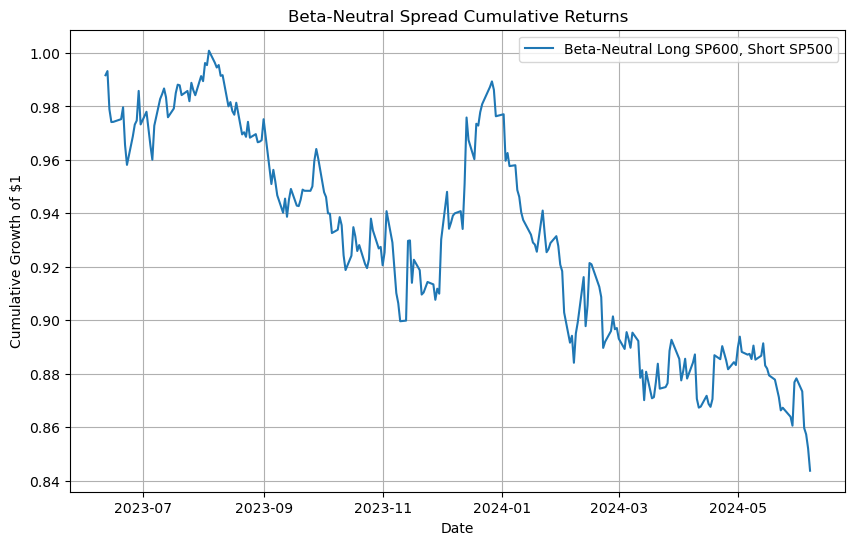

In [21]:
# --- 4. Construct Beta-Neutral Strategy Returns ---
# Strategy return on each day = SP600_return - SP_500- (beta-1) * SP500_return
strategy_returns = returns_df['SP600'] - (beta-1) * returns_df['SP500'] - returns_df["SP500"]

# --- 5. Backtest: Cumulative Performance of the Spread ---
# Assuming $1 initial capital in the spread
cumulative_performance = (1 + strategy_returns).cumprod()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cumulative_performance, label='Beta-Neutral Long SP600, Short SP500')
plt.title('Beta-Neutral Spread Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.legend()
plt.grid(True)
plt.show()

## Observations
1. Dogshit strategy (obviously because of the amazing performance of Mag7)
2. Lets try now "Hedging" the effects of Mag7